# read SolO cdf data, convert and plot


In [1]:
import numpy as np
import scipy.io
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import  DateFormatter
from datetime import timedelta
import seaborn as sns
import datetime
import astropy
import astropy.constants as const
from sunpy.time import parse_time
import time
import pickle
import sys
import os
import urllib
import json
import importlib
import pandas as pd
import copy
import openpyxl
import h5py
import heliopy.data.spice as spicedata
import heliopy.spice as spice
import heliosat



from heliocats import plot as hp
importlib.reload(hp) #reload again while debugging

from heliocats import data as hd
importlib.reload(hd) #reload again while debugging

from heliocats import cats as hc
importlib.reload(hc) #reload again while debugging

from heliocats import stats as hs
importlib.reload(hs) #reload again while debugging

#where the in situ data files are located is read 
#from config.py 
import config
importlib.reload(config)
from config import data_path
from config import data_path_ML


########### make directories first time if not there

resdir='results'
if os.path.isdir(resdir) == False: os.mkdir(resdir)

datadir='data'
if os.path.isdir(datadir) == False: os.mkdir(datadir)

indexdir='icmecat/indices_icmecat' 
if os.path.isdir(indexdir) == False: os.mkdir(indexdir) 

catdir='icmecat'
if os.path.isdir(catdir) == False: os.mkdir(catdir)

icplotsdir='icmecat/plots_icmecat/' 
if os.path.isdir(icplotsdir) == False: os.mkdir(icplotsdir) 

plt.rcParams["figure.figsize"] = (15,5)


from astropy.constants import au
#define AU in km
AU=au.value/1e3
print('done')

done


## read SolO data and convert to recarray


In [2]:

#normal time resolution
#DATAPATH = "/nas/helio/data/SolarOrbiter/MAG/level2/mag_rtn_norm"

#1 minute time resolution
DATAPATH = "/nas/helio/data/SolarOrbiter/MAG/level2/mag_rtn_norm_1min"


class SOIO_EXT(heliosat.SOIO):
    def get_data_files(self, *args):
        files = os.listdir(DATAPATH)
        files.sort()
        files = [os.path.join(DATAPATH, f) for f in files]
        return files, [self.get_data_version("mag", datetime.datetime.now())] * len(files)
  

a = SOIO_EXT()
#time for 7 days
time = [datetime.datetime(2020, 6, 1) + datetime.timedelta(minutes=i) for i in range(60 * 24 * 60 )]
time_mat=mdates.date2num(time) 


#_, b_soio = SOIO_EXT().get_data(t_soio, "mag", frame="HEEQ")

# t_soio = [datetime.datetime(2020, 5, 27) + datetime.timedelta(hours=i) for i in range(24 * 7)]
# _, b_soio = SOIO_EXT().get_data(t_soio, "mag", frame="HEEQ", cache=True, smoothing="kernel",
#                                 smoothing_scale=240, remove_nans=True)


#original data
print('get data')
t2, b_soio = SOIO_EXT().get_data(time, "mag")#,frame="HEEQ")
t1=parse_time(t2,format='unix').datetime
tm_mat=mdates.date2num(t1) 

smag=np.zeros(np.size(time),dtype=[('time',object),('bx', float),('by', float),\
        ('bz', float),('bt', float),\
        ('vt', float),('np', float), ('tp', float),\
                                   ('x', float),('y', float),('z', float),\
        ('r', float),('lat', float),('lon', float)])  
smag = smag.view(np.recarray) 

print('interpolate')
smag.time=time
smag.bx = np.interp(time_mat, tm_mat, b_soio[:, 0])
smag.by = np.interp(time_mat, tm_mat, b_soio[:, 1])
smag.bz = np.interp(time_mat, tm_mat, b_soio[:, 2])
smag.bt =np.sqrt(smag.bx**2+smag.by**2+smag.bz**2)


print('Solo position')


#add position

frame='HEEQ'
spice.furnish(spicedata.get_kernel('solo_2020'))
solo=spice.Trajectory('Solar Orbiter')
solo.generate_positions(smag.time, 'Sun',frame)
solo.change_units(astropy.units.AU)
[smag.r, smag.lat, smag.lon]=hd.cart2sphere(solo.x,solo.y,solo.z)


#convert to degree
smag.lat=np.rad2deg(smag.lat)
smag.lon=np.rad2deg(smag.lon)


smag.x=solo.x.value
smag.y=solo.y.value
smag.z=solo.z.value


#maybe use RTN to SCEQ or HEEQ from hd.

filemag=data_path+'solo_2020_june_july_rtn.p'
pickle.dump(smag, open(filemag, "wb"))
print('done')

get data
interpolate
Solo position
done


## Plot data

/home/cmoestl/miniconda/envs/helio/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/cmoestl/miniconda/envs/helio/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


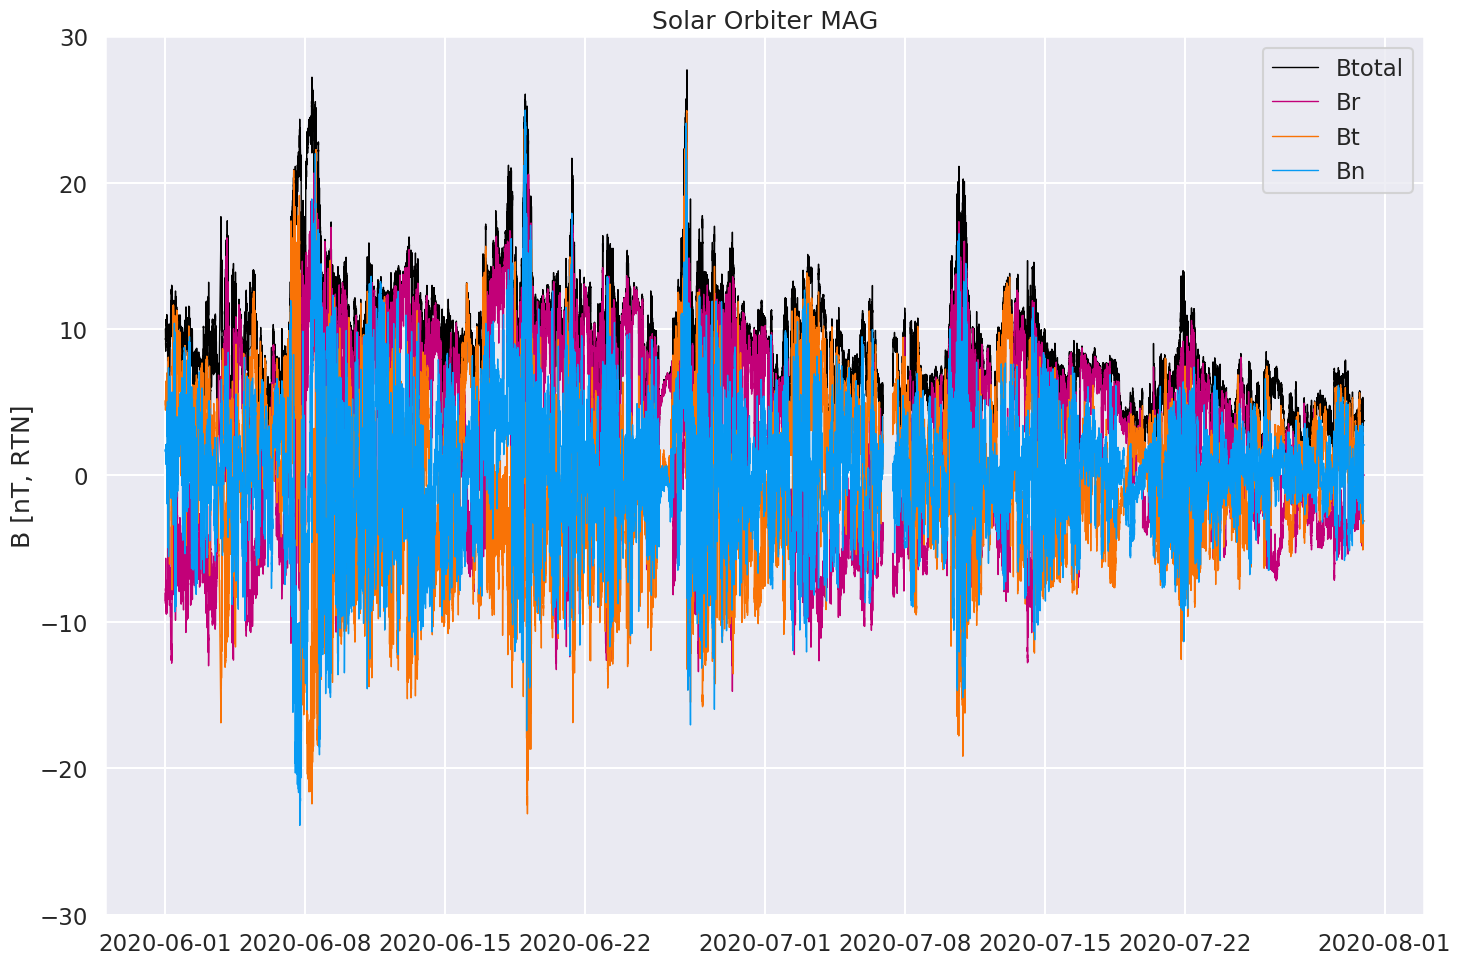

In [4]:
%matplotlib inline

filemag=data_path+'solo_2020_june_july_rtn.p'
sm=pickle.load(open(filemag, "rb" ) ) 

filewin=data_path+'wind_2018_now_heeq.p'
[win,hwin]=pickle.load(open(filewin, "rb" ) )

sns.set_context("talk")     
sns.set_style('darkgrid')

plt.figure(1,figsize=(15, 10),dpi=100)

ax = plt.subplot(111)
plt.title('Solar Orbiter MAG')
ax.plot(sm.time, sm.bt, "k-", lw=1, label='Btotal')
ax.plot(sm.time, sm.bx, "r-", color="xkcd:magenta", lw=1, label='Br')
ax.plot(sm.time, sm.by, "g-", color="xkcd:orange", lw=1,label='Bt')
ax.plot(sm.time, sm.bz, "b-", color="xkcd:azure", lw=1,label='Bn')
plt.ylabel('B [nT, RTN]')
ax.set_ylim([-30,30])
ax.legend()


plt.tight_layout()



plt.savefig('results/solo_june_july2020.png',dpi=100)

### old code

In [3]:
ax2 = plt.subplot(212,sharex=ax)
plt.title('Wind MFI')
ax2.plot(win.time, win.bt, "k-", lw=1, label='Btotal')
ax2.plot(win.time, win.bx, "r-", color="xkcd:magenta", lw=1, label='Bx')
ax2.plot(win.time, win.by, "g-", color="xkcd:orange", lw=1,label='By')
ax2.plot(win.time, win.bz, "b-", color="xkcd:azure", lw=1,label='Bz')
ax2.set_ylim([-30,30])
plt.ylabel('B [nT, HEEQ]')
ax2.legend()





/home/cmoestl/miniconda/envs/helio/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/cmoestl/miniconda/envs/helio/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/cmoestl/miniconda/envs/helio/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


Error in callback <function flush_figures at 0x7f751f3d1560> (for post_execute):


KeyboardInterrupt: 

In [14]:
filemag=data_path+'solo_april2020.p'
sm=pickle.load(open(filemag, "rb" ) ) 


filewin=data_path+'wind_2018_now_gse.p'
[win,hwin]=pickle.load(open(filewin, "rb" ) )

#%matplotlib inline

#%matplotlib
#hp.plot_insitu_measure(sm, '2020-Apr-18 12:00','2020-Apr-21 12:00', 'Solo', 'results/')
#hp.plot_insitu_measure(win, '2020-Apr-18 12:00','2020-Apr-23 12:00', 'Wind', 'results/')


print()
print()

#solo
sicme_start_time=parse_time('2020-04-19T05:07Z').datetime
smo_start_time=parse_time('2020-04-19T08:59Z').datetime
smo_end_time=parse_time('2020-04-20T09:15Z').datetime

print('SolO times:',sicme_start_time, smo_start_time,smo_end_time)

#index of times
sicme_start_ind=np.where(sicme_start_time==sm.time)[0][0]
smo_start_ind=np.where(smo_start_time==sm.time)[0][0]
smo_end_ind=np.where(smo_end_time==sm.time)[0][0]

print('HEEQ position of SolO r/lat/lon at icme_start_time:',np.round(sm.r[sicme_start_ind],3),np.round(sm.lat[sicme_start_ind],2),np.round(sm.lon[sicme_start_ind],2))
print('HEEQ position of SolO r/lat/lon at mo_start_time:',np.round(sm.r[smo_start_ind],3),np.round(sm.lat[smo_start_ind],2),np.round(sm.lon[smo_start_ind],2))
print('HEEQ position of SolO r/lat/lon at mo_end_time:',np.round(sm.r[smo_end_ind],3),np.round(sm.lat[smo_end_ind],2),np.round(sm.lon[smo_end_ind],2))



print('SolO ICME duration hours ', np.round((smo_end_time-sicme_start_time).total_seconds()/3600,2))
print('SolO MO duration hours ', np.round((smo_end_time-smo_start_time).total_seconds()/3600,2))
print()

#earth
wicme_start_time=parse_time('2020-04-20T01:34Z').datetime
wmo_start_time=parse_time('2020-04-20T07:56Z').datetime
wmo_end_time=parse_time('2020-04-21T11:18Z').datetime

print('Wind times:',wicme_start_time, wmo_start_time,wmo_end_time)



print('Wind ICME duration hours ', np.round((wmo_end_time-wicme_start_time).total_seconds()/3600,2))
print('Wind MO duration hours ', np.round((wmo_end_time-wmo_start_time).total_seconds()/3600,2))


#index of times
wicme_start_ind=np.where(wicme_start_time==win.time)[0][0]
wmo_start_ind=np.where(wmo_start_time==win.time)[0][0]
wmo_end_ind=np.where(wmo_end_time==win.time)[0][0]

print('HEEQ position of Wind r/lat/lon at icme_start_time:',np.round(win.r[wicme_start_ind],3),np.round(win.lat[wicme_start_ind],2),np.round(win.lon[wicme_start_ind],2))
print('HEEQ position of Wind r/lat/lon at mo_start_time:',np.round(win.r[wmo_start_ind],3),np.round(win.lat[wmo_start_ind],2),np.round(win.lon[wmo_start_ind],2))
print('HEEQ position of Wind r/lat/lon at mo_end_time:',np.round(win.r[wmo_end_ind],3),np.round(win.lat[wmo_end_ind],2),np.round(win.lon[wmo_end_ind],2))





sns.set_context("talk")     
sns.set_style('darkgrid')

plt.figure(3,figsize=(12, 10),dpi=100)

ax = plt.subplot(211)
plt.title('Solar Orbiter MAG')
ax.plot(sm.time, sm.bt, "k-", lw=1)
ax.plot(sm.time, sm.bx, "r-", color="xkcd:magenta", lw=1, label='Bx')
ax.plot(sm.time, sm.by, "g-", color="xkcd:orange", lw=1,label='By')
ax.plot(sm.time, sm.bz, "b-", color="xkcd:azure", lw=1,label='Bz')


    
#plot vertical lines
ax.plot_date([sicme_start_time,sicme_start_time],[-500,500],'-k',linewidth=1)            
ax.plot_date([smo_start_time,smo_start_time],[-500,500],'-k',linewidth=1)            
ax.plot_date([smo_end_time,smo_end_time],[-500,500],'-k',linewidth=1)            



plt.ylabel('B [nT, RTN]')

plotstart=datetime.datetime(2020, 4, 18)
plotend=datetime.datetime(2020, 4,22)
plt.xlim(plotstart,plotend)
plt.ylim(-30,30)


#position on figure
textstart=plotstart+datetime.timedelta(hours=2)
plt.text(textstart,25,'HEEQ R/lat/lon: '+str(np.round(sm.r[sicme_start_ind],3))+' ' +str(np.round(sm.lat[sicme_start_ind],2))+'  '+\
         str(np.round(sm.lon[sicme_start_ind],2)),fontsize=13)





ax2 = plt.subplot(212)
plt.title('Wind MFI')
ax2.plot(win.time, -win.bx,'-r', color="xkcd:magenta",linewidth=1,label='By')
ax2.plot(win.time, -win.by, "g-", color="xkcd:orange", lw=1,label='By')
ax2.plot(win.time, win.bz, "b-", color="xkcd:azure", lw=1,label='Bz')
ax2.plot(win.time, win.bt, "k-", lw=1,label='Bt')

#plot vertical lines
ax2.plot_date([wicme_start_time,wicme_start_time],[-500,500],'-k',linewidth=1)            
ax2.plot_date([wmo_start_time,wmo_start_time],[-500,500],'-k',linewidth=1)            
ax2.plot_date([wmo_end_time,wmo_end_time],[-500,500],'-k',linewidth=1)            



plt.ylabel('B [nT, HEE]')


plotstart=datetime.datetime(2020, 4, 18)
plotend=datetime.datetime(2020, 4,22)
plt.xlim(plotstart,plotend)
plt.ylim(-30,30)


#position on figure
textstart=plotstart+datetime.timedelta(hours=2)
plt.text(textstart,25,'HEEQ R/lat/lon: '+str(np.round(win.r[wicme_start_ind],3))+' ' +str(np.round(win.lat[wicme_start_ind],2))+'  '+\
         str(np.round(win.lon[wicme_start_ind],2)),fontsize=13)

plt.legend(loc=3,ncol=4,fontsize=13)
plt.tight_layout()

plt.savefig('results/solo_wind_cme_april2020.png')
plt.savefig('results/solo_wind_cme_april2020.eps')



SolO times: 2020-04-19 05:07:00 2020-04-19 08:59:00 2020-04-20 09:15:00
HEEQ position of SolO r/lat/lon at icme_start_time: 0.806 -3.9 -4.61
HEEQ position of SolO r/lat/lon at mo_start_time: 0.805 -3.89 -4.56
HEEQ position of SolO r/lat/lon at mo_end_time: 0.799 -3.77 -4.28
SolO ICME duration hours  28.13
SolO MO duration hours  24.27

Wind times: 2020-04-20 01:34:00 2020-04-20 07:56:00 2020-04-21 11:18:00
Wind ICME duration hours  33.73
Wind MO duration hours  27.37
HEEQ position of Wind r/lat/lon at icme_start_time: 0.996 -5.21 0.19
HEEQ position of Wind r/lat/lon at mo_start_time: 0.996 -5.19 0.19
HEEQ position of Wind r/lat/lon at mo_end_time: 0.996 -5.09 0.18


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [7]:
#CME 2
DATAPATH = "data/solo_mag/event2"


class SOIO_EXT(heliosat.SOIO):
    def get_data_files(self, *args):
        files = os.listdir(DATAPATH)
        files.sort()
        files = [os.path.join(DATAPATH, f) for f in files]
        return files, [self.get_data_version("mag", datetime.datetime.now())] * len(files)
  

a = SOIO_EXT()
#time for 7 days
time = [datetime.datetime(2020, 5, 27) + datetime.timedelta(minutes=i) for i in range(60 * 24 * 7 )]
time_mat=mdates.date2num(time) 



#_, b_soio = SOIO_EXT().get_data(t_soio, "mag", frame="HEEQ")

# t_soio = [datetime.datetime(2020, 5, 27) + datetime.timedelta(hours=i) for i in range(24 * 7)]
# _, b_soio = SOIO_EXT().get_data(t_soio, "mag", frame="HEEQ", cache=True, smoothing="kernel",
#                                 smoothing_scale=240, remove_nans=True)


#original data
print('get data')
t2, b_soio = SOIO_EXT().get_data(time, "mag")#,frame="HEEQ")
t1=parse_time(t2,format='unix').datetime
tm_mat=mdates.date2num(t1) 

smag=np.zeros(np.size(time),dtype=[('time',object),('bx', float),('by', float),\
        ('bz', float),('bt', float),\
        ('vt', float),('np', float), ('tp', float),\
                                   ('x', float),('y', float),('z', float),\
        ('r', float),('lat', float),('lon', float)])  
smag = smag.view(np.recarray) 

print('interpolate')
smag.time=time
smag.bx = np.interp(time_mat, tm_mat, b_soio[:, 0])
smag.by = np.interp(time_mat, tm_mat, b_soio[:, 1])
smag.bz = np.interp(time_mat, tm_mat, b_soio[:, 2])
smag.bt =np.sqrt(smag.bx**2+smag.by**2+smag.bz**2)


print('Solo position')


#add position

frame='HEEQ'
spice.furnish(spicedata.get_kernel('solo_2020'))
solo=spice.Trajectory('Solar Orbiter')
solo.generate_positions(smag.time, 'Sun',frame)
solo.change_units(astropy.units.AU)
[smag.r, smag.lat, smag.lon]=hd.cart2sphere(solo.x,solo.y,solo.z)


#convert to degree
smag.lat=np.rad2deg(smag.lat)
smag.lon=np.rad2deg(smag.lon)


smag.x=solo.x.value
smag.y=solo.y.value
smag.z=solo.z.value




filemag='data/solo_may2020.p'
pickle.dump(smag, open(filemag, "wb"))

get data
interpolate
Solo position


In [15]:
filemag='data/solo_may2020.p'
sm=pickle.load(open(filemag, "rb" ) ) 

filewin='data/wind_2018_now_gse.p'
[win,hwin]=pickle.load(open(filewin, "rb" ) )





#%matplotlib inline

#%matplotlib
#hp.plot_insitu_measure(sm, '2020-May-27 12:00','2020-Jun-2 12:00', 'Solo', 'results/')
#hp.plot_insitu_measure(win, '2020-May-27 12:00','2020-Jun-2 12:00', 'Wind', 'results/')








#solo
sicme_start_time=parse_time('2020-05-28T12:45Z').datetime
smo_start_time=parse_time('2020-05-28T19:44Z').datetime
smo_end_time=parse_time('2020-05-29T10:53Z').datetime

print('SolO times:',sicme_start_time, smo_start_time,smo_end_time)

#index of times
sicme_start_ind=np.where(sicme_start_time==sm.time)[0][0]
smo_start_ind=np.where(smo_start_time==sm.time)[0][0]
smo_end_ind=np.where(smo_end_time==sm.time)[0][0]

print('HEEQ position of SolO r/lat/lon at icme_start_time:',np.round(sm.r[sicme_start_ind],3),np.round(sm.lat[sicme_start_ind],2),np.round(sm.lon[sicme_start_ind],2))
print('HEEQ position of SolO r/lat/lon at mo_start_time:',np.round(sm.r[smo_start_ind],3),np.round(sm.lat[smo_start_ind],2),np.round(sm.lon[smo_start_ind],2))
print('HEEQ position of SolO r/lat/lon at mo_end_time:',np.round(sm.r[smo_end_ind],3),np.round(sm.lat[smo_end_ind],2),np.round(sm.lon[smo_end_ind],2))



print('SolO ICME duration hours ', np.round((smo_end_time-sicme_start_time).total_seconds()/3600,2))
print('SolO MO duration hours ', np.round((smo_end_time-smo_start_time).total_seconds()/3600,2))
print()

#earth
wicme_start_time=parse_time('2020-05-29T22:12Z').datetime
wmo_start_time=parse_time('2020-05-30T04:20Z').datetime
wmo_end_time=parse_time('2020-05-30T13:16Z').datetime

print('Wind times:',wicme_start_time, wmo_start_time,wmo_end_time)



print('Wind ICME duration hours ', np.round((wmo_end_time-wicme_start_time).total_seconds()/3600,2))
print('Wind MO duration hours ', np.round((wmo_end_time-wmo_start_time).total_seconds()/3600,2))


#index of times
wicme_start_ind=np.where(wicme_start_time==win.time)[0][0]
wmo_start_ind=np.where(wmo_start_time==win.time)[0][0]
wmo_end_ind=np.where(wmo_end_time==win.time)[0][0]

print('HEEQ position of Wind r/lat/lon at icme_start_time:',np.round(win.r[sicme_start_ind],3),np.round(win.lat[sicme_start_ind],2),np.round(win.lon[sicme_start_ind],2))
print('HEEQ position of Wind r/lat/lon at mo_start_time:',np.round(win.r[smo_start_ind],3),np.round(win.lat[smo_start_ind],2),np.round(win.lon[smo_start_ind],2))
print('HEEQ position of Wind r/lat/lon at mo_end_time:',np.round(win.r[smo_end_ind],3),np.round(win.lat[smo_end_ind],2),np.round(win.lon[smo_end_ind],2))























sns.set_context("talk")     
sns.set_style('darkgrid')

plt.figure(3,figsize=(12, 10),dpi=100)

ax = plt.subplot(211)
plt.title('Solar Orbiter MAG')
ax.plot(sm.time, sm.bt, "k-", lw=1)
ax.plot(sm.time, sm.bx, "r-", color="xkcd:magenta", lw=1, label='Bx')
ax.plot(sm.time, sm.by, "g-", color="xkcd:orange", lw=1,label='By')
ax.plot(sm.time, sm.bz, "b-", color="xkcd:azure", lw=1,label='Bz')
plt.ylabel('B [nT, RTN]')



#plot vertical lines
ax.plot_date([sicme_start_time,sicme_start_time],[-500,500],'-k',linewidth=1)            
ax.plot_date([smo_start_time,smo_start_time],[-500,500],'-k',linewidth=1)            
ax.plot_date([smo_end_time,smo_end_time],[-500,500],'-k',linewidth=1)            



plotstart=datetime.datetime(2020, 5, 27)
plotend=datetime.datetime(2020, 6,1)
plt.xlim(plotstart,plotend)



#position on figure
textstart=plotstart+datetime.timedelta(hours=2)
plt.text(textstart,25,'HEEQ R/lat/lon: '+str(np.round(sm.r[sicme_start_ind],3))+' ' +str(np.round(sm.lat[sicme_start_ind],2))+'  '+\
         str(np.round(sm.lon[sicme_start_ind],2)),fontsize=13)




plt.ylim(-30,30)



ax2 = plt.subplot(212)
plt.title('Wind MFI')
ax2.plot(win.time, -win.bx,'-r', color="xkcd:magenta",linewidth=1,label='By')
ax2.plot(win.time, -win.by, "g-", color="xkcd:orange", lw=1,label='By')
ax2.plot(win.time, win.bz, "b-", color="xkcd:azure", lw=1,label='Bz')
ax2.plot(win.time, win.bt, "k-", lw=1,label='Bt')
plt.ylabel('B [nT, HEE]')



#plot vertical lines
ax2.plot_date([wicme_start_time,wicme_start_time],[-500,500],'-k',linewidth=1)            
ax2.plot_date([wmo_start_time,wmo_start_time],[-500,500],'-k',linewidth=1)            
ax2.plot_date([wmo_end_time,wmo_end_time],[-500,500],'-k',linewidth=1)            



plotstart=datetime.datetime(2020, 5, 27)
plotend=datetime.datetime(2020, 6,1)
plt.xlim(plotstart,plotend)


#position on figure
textstart=plotstart+datetime.timedelta(hours=2)
plt.text(textstart,25,'HEEQ R/lat/lon: '+str(np.round(win.r[wicme_start_ind],3))+' ' +str(np.round(win.lat[wicme_start_ind],2))+'  '+\
         str(np.round(win.lon[wicme_start_ind],2)),fontsize=13)

plt.ylim(-30,30)



plt.ylabel('B [nT, HEE]')
plt.legend(loc=3,ncol=4)
plt.title('Wind MFI')

plt.legend(loc=3,ncol=4,fontsize=13)



plt.tight_layout()



plt.savefig('results/solo_wind_cme_may2020.png')
plt.savefig('results/solo_wind_cme_may2020.eps')



FileNotFoundError: [Errno 2] No such file or directory: 'data/solo_may2020.p'